In [ ]:
!pip install yfinance pandas matplotlib scikit-learn

## Data Load & Cleaning

In [ ]:
import yfinance as yf
import pandas as pd

# Step 1: Download historical data for USD-INR and Gold (USD/ounce)
usd_inr = yf.download('INR=X', period='1y', interval='1d')[['Close']]
gold_usd = yf.download('GC=F', period='1y', interval='1d')[['Close']]

# Step 2: Rename columns
usd_inr.columns = ['USD_INR']
gold_usd.columns = ['Gold_USD_per_ounce']

# Step 3: Drop missing values
usd_inr.dropna(inplace=True)
gold_usd.dropna(inplace=True)

# Step 4: Merge datasets on Date
df = pd.merge(usd_inr, gold_usd, left_index=True, right_index=True)

# Step 5: Calculate 22K gold rate in INR per gram
# 1 ounce = 28.3495 grams, and 22K = 91.67% purity but we fine tuned so if need we take 0.9137
df['Gold_INR_per_gram_22K'] = (df['Gold_USD_per_ounce'] * df['USD_INR']) / 31.1035 * 0.9167

# Step 6: Reset index and save
df.reset_index(inplace=True)
df.to_csv('gold_22k_usd_inr_data.csv', index=False)

print("✅ Done! Gold 22K INR per gram data saved to 'gold_22k_usd_inr_data.csv'")


In [178]:
usd_inr.tail()

,USD_INR
Date,
2025-04-01,85.468102
2025-04-02,85.610100
2025-04-03,85.651199
2025-04-04,85.282898
2025-04-05,85.482002


In [180]:
gold_usd.tail()

,Gold_USD_per_ounce
Date,
2025-03-31,3122.800049
2025-04-01,3118.899902
2025-04-02,3139.899902
2025-04-03,3097.000000
2025-04-04,3056.100098


## EDA
### check null values
### plot and check correlation

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('gold_22k_usd_inr_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   251 non-null    object 
 1   USD_INR                251 non-null    float64
 2   Gold_USD_per_ounce     251 non-null    float64
 3   Gold_INR_per_gram_22K  251 non-null    float64
dtypes: float64(3), object(1)
memory usage: 8.0+ KB


In [184]:
df.describe()

,USD_INR,Gold_USD_per_ounce,Gold_INR_per_gram_22K
count,251.000000,251.000000,251.000000
mean,84.576868,2597.203982,7110.557357
std,1.283633,220.560108,699.578104
min,83.093399,2291.399902,6183.221442
25%,83.561050,2389.150024,6453.558857
50%,83.983597,2615.000000,7131.210158
75%,85.535450,2736.800049,7458.002591
max,87.588303,3139.899902,8692.058374


In [186]:
df.isnull()

,Date,USD_INR,Gold_USD_per_ounce,Gold_INR_per_gram_22K
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
246,False,False,False,False
247,False,False,False,False
248,False,False,False,False
249,False,False,False,False


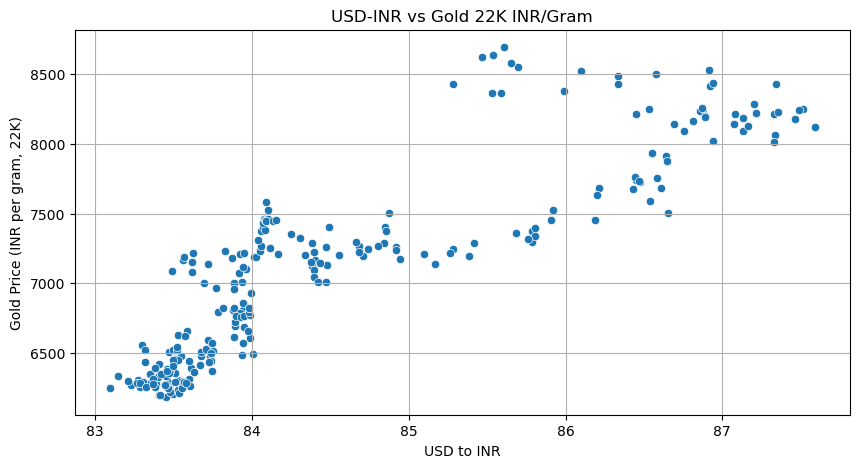


Correlation:
                         USD_INR  Gold_INR_per_gram_22K
USD_INR                1.000000               0.880179
Gold_INR_per_gram_22K  0.880179               1.000000


In [188]:
# Plot USD-INR vs Gold
plt.figure(figsize=(10,5))
sns.scatterplot(x='USD_INR', y='Gold_INR_per_gram_22K', data=df)
plt.title('USD-INR vs Gold 22K INR/Gram')
plt.xlabel('USD to INR')
plt.ylabel('Gold Price (INR per gram, 22K)')
plt.grid()
plt.show()

# Check correlation
correlation = df[['USD_INR', 'Gold_INR_per_gram_22K']].corr()
print("\nCorrelation:\n", correlation)

## Model Training

In [ ]:
df = pd.read_csv('gold_usd_inr_data.csv')  
print(df.columns)

In [228]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Load your final cleaned data
df = pd.read_csv('gold_usd_inr_data.csv')

# Add 22K column
df['Gold_INR_per_gram_22K'] = df['Gold_INR_per_gram'] * 0.9137

# Feature and target
X = df[['USD_INR', 'Gold_USD_per_ounce']]
y = df['Gold_INR_per_gram_22K']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
ridge = Ridge()
param_dist = {'alpha': np.linspace(0.01, 10, 100)}
search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=20, cv=5, scoring='r2', random_state=42)
search.fit(X_train_scaled, y_train)

# Best model
best_ridge = search.best_estimator_
y_pred = best_ridge.predict(X_test_scaled)

# Evaluation
print("Ridge model with best hyperparameter trained!")
print(f" Best alpha: {search.best_params_['alpha']:.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

# Save model and scaler
joblib.dump(best_ridge, 'ridge_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


Ridge model with best hyperparameter trained!
 Best alpha: 0.0100
MSE: 46.16
R² Score: 0.9999


['scaler.pkl']

## Model2
### future forecast goldprice

In [ ]:
!pip install prophet


15:44:02 - cmdstanpy - INFO - Chain [1] start processing
15:44:02 - cmdstanpy - INFO - Chain [1] done processing


Date Range: 2024-04-08 00:00:00 to 2025-04-04 00:00:00
 Total Records: 251
            ds            y
246 2025-03-31  8609.254928
247 2025-04-01  8591.395562
248 2025-04-02  8663.612672
249 2025-04-03  8549.345636
250 2025-04-04  8400.163621


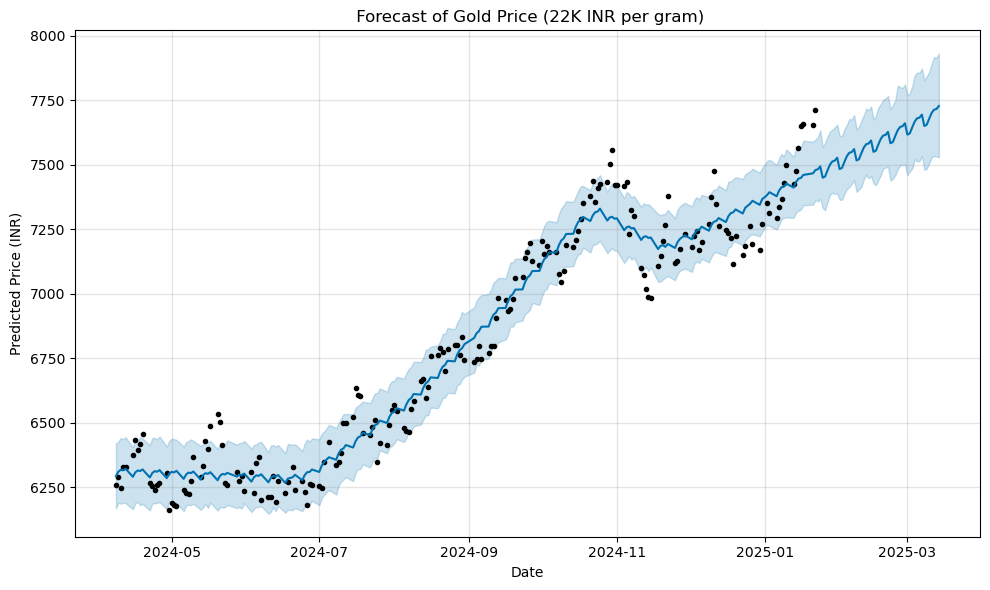

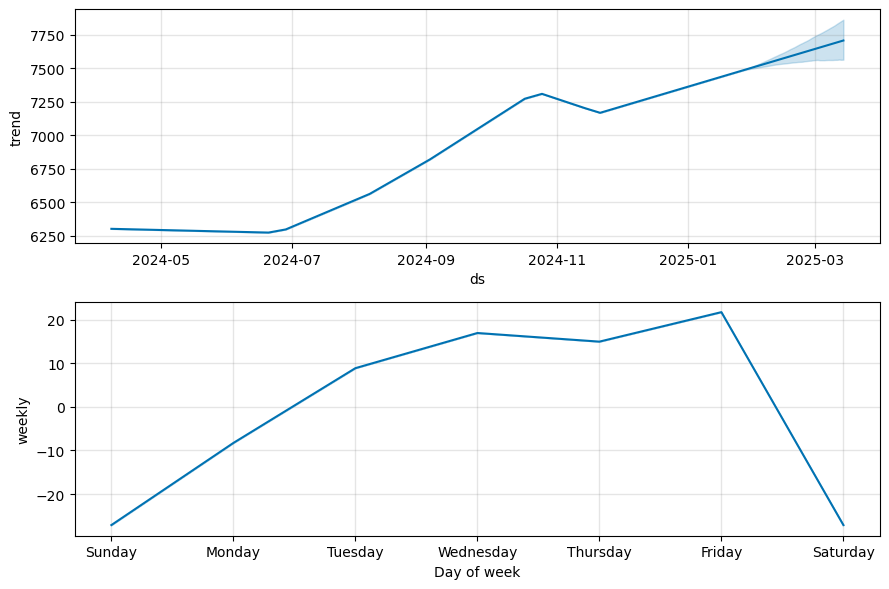


 Forecast vs Actual:
            ds     yhat        y
26 2025-03-03  7645.94  8147.33
27 2025-03-04  7667.88  8189.42
28 2025-03-05  7680.72  8194.88
29 2025-03-06  7683.51  8167.73
30 2025-03-07  7695.05  8156.83
31 2025-03-10  7679.34  8113.23
32 2025-03-11  7701.28  8201.10
33 2025-03-12  7714.12  8260.18
34 2025-03-13  7716.91  8400.73
35 2025-03-14  7728.45  8389.05
 Forecast saved to 'forecast_gold_22k.csv'


In [250]:

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


df = pd.read_csv('gold_22k_usd_inr_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Keep only date and gold price columns
df = df[['Date', 'Gold_INR_per_gram_22K']].dropna()
df.columns = ['ds', 'y']  # Prophet needs 'ds' for date, 'y' for value

# Optional — check data health
print("Date Range:", df['ds'].min(), "to", df['ds'].max())
print(" Total Records:", len(df))
print(df.tail())

# Split train/test (80% train)
split_index = int(0.8 * len(df))
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Fit the Prophet model
model = Prophet()
model.fit(train_df)

#  Forecast future gold prices (e.g., next 180 days)
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

#  Visualize the forecast
model.plot(forecast)
plt.title(" Forecast of Gold Price (22K INR per gram)")
plt.xlabel("Date")
plt.ylabel("Predicted Price (INR)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Show components (trend, weekly, yearly seasonality)
model.plot_components(forecast)
plt.tight_layout()
plt.show()


# Compare predicted vs actual (on test data)
merged = forecast[['ds', 'yhat']].merge(test_df, on='ds')
merged['yhat'] = merged['yhat'].round(2)
merged['y'] = merged['y'].round(2)

print("\n Forecast vs Actual:\n", merged.tail(10))

# Save forecast for UI or dashboard
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_gold_22k.csv', index=False)
print(" Forecast saved to 'forecast_gold_22k.csv'")

## UI

In [ ]:
import gradio as gr
import pandas as pd
import joblib
from prophet.plot import plot_plotly
import plotly.graph_objects as go

# Load Model 1 (Ridge)
ridge_model = joblib.load("ridge_model.pkl")
scaler = joblib.load("scaler.pkl")

# Load Prophet Forecast
forecast_df = pd.read_csv("forecast_gold_22k.csv")
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

# --- Function for Model 1 ---
def predict_model1(usd_inr, gold_usd):
    input_df = pd.DataFrame([[usd_inr, gold_usd]], columns=["USD_INR", "Gold_USD_per_ounce"])
    scaled = scaler.transform(input_df)
    prediction = ridge_model.predict(scaled)[0]
    return f"💰 Predicted 22K Gold Rate: ₹{round(prediction, 2)}"

# --- Function for Model 2 ---
def show_forecast(days=180):
    forecast_plot = forecast_df.copy().tail(days)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast_plot['ds'], y=forecast_plot['yhat'],
                             mode='lines', name='Predicted'))
    fig.add_trace(go.Scatter(x=forecast_plot['ds'], y=forecast_plot['yhat_upper'],
                             mode='lines', name='Upper Bound', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=forecast_plot['ds'], y=forecast_plot['yhat_lower'],
                             mode='lines', name='Lower Bound', line=dict(dash='dot')))
    fig.update_layout(title="📈 Gold Price Forecast (22K INR/Gram)",
                      xaxis_title="Date", yaxis_title="Price (INR)")
    return fig

# --- Gradio Interface ---
with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Gold Price Prediction Dashboard")
    
    with gr.Tab("🔢 Model 1: What-If Simulation"):
        usd_inr_input = gr.Number(label="USD to INR (e.g., 85.53)", value=85.5)
        gold_usd_input = gr.Number(label="Gold USD per ounce (e.g., 2321.70)", value=2320.0)
        output1 = gr.Textbox(label="Predicted Gold Price")
        predict_btn = gr.Button("Predict")
        predict_btn.click(fn=predict_model1, inputs=[usd_inr_input, gold_usd_input], outputs=output1)
    
    with gr.Tab("📆 Model 2: Forecast (Next 6 Months)"):
        days_slider = gr.Slider(minimum=30, maximum=180, step=10, label="Show next N days", value=180)
        output2 = gr.Plot()
        forecast_btn = gr.Button("Show Forecast")
        forecast_btn.click(fn=show_forecast, inputs=[days_slider], outputs=output2)

demo.launch()
